<a href="https://colab.research.google.com/github/Maaslak/GSN-adversarial_attension/blob/data_preprocessing/create_adversarial_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](colab_notebook_link_todo)

In [2]:
%tensorflow_version 2.x
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image
from zipfile import ZipFile 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TensorFlow 2.x selected.


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!rm -rf sample_data

In [0]:
!mkdir /root/.kaggle
!echo '{"username":"USERNAME","key":"API_KEY"}' > /root/.kaggle/kaggle.json

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [11]:
!kaggle datasets download "chetankv/dogs-cats-images"

 99% 430M/435M [00:12<00:00, 43.0MB/s]
100% 435M/435M [00:13<00:00, 33.1MB/s]


In [0]:
!unzip -q dogs-cats-images.zip

In [0]:
test_dir="dog vs cat/dataset/test_set"
train_dir="dog vs cat/dataset/training_set"

train_dir_cats = train_dir + '/cats'
train_dir_dogs = train_dir + '/dogs'
test_dir_cats = test_dir + '/cats'
test_dir_dogs = test_dir + '/dogs'

In [0]:
import pathlib
DATA_DIR = "dog vs cat/dataset/"
train_dir = pathlib.Path(DATA_DIR + "training_set")
test_dir = pathlib.Path(DATA_DIR + "test_set")

In [15]:
train_image_count = len(list(train_dir.glob('*/*.jpg')))
test_image_count = len(list(test_dir.glob('*/*.jpg')))
(train_image_count, test_image_count)

(8000, 2000)

In [16]:
CLASS_NAMES = np.array([item.name for item in train_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['cats', 'dogs'], dtype='<U4')

In [0]:
data_generator = ImageDataGenerator(rescale = 1.0/255.0, zoom_range = 0.2)

In [0]:
def list_files(data_dir):
  return tf.data.Dataset.list_files(str(data_dir/'*/*'))


train_list_ds = list_files(train_dir)
test_list_ds = list_files(test_dir)

In [21]:
for f in train_list_ds.take(5):
  print(f.numpy())

b'dog vs cat/dataset/training_set/dogs/dog.1857.jpg'
b'dog vs cat/dataset/training_set/cats/cat.3238.jpg'
b'dog vs cat/dataset/training_set/dogs/dog.278.jpg'
b'dog vs cat/dataset/training_set/dogs/dog.23.jpg'
b'dog vs cat/dataset/training_set/dogs/dog.1044.jpg'


In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])


In [0]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [0]:
AUTOTUNE = 100

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_labeled_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_labeled_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [26]:
for image, label in train_labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())


Image shape:  (224, 224, 3)
Label:  [ True False]


In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
train_ds = prepare_for_training(train_labeled_ds)

image_batch, label_batch = next(iter(train_ds))

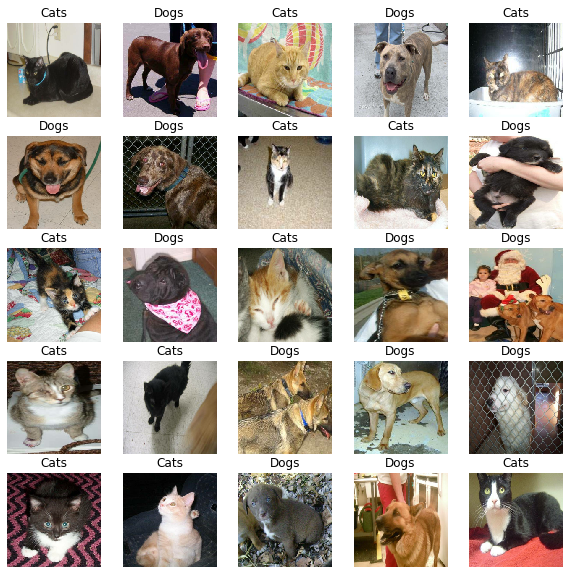

In [29]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

show_batch(image_batch.numpy(), label_batch.numpy())